# Notebook C — Make RHS (random amount / amplitude / location)

This notebook defines and validates a **family of RHS sources** to be used for:

- **Training set** (direct solves)
- **Testing set**
- Later: **iterative refinement / preconditioning** experiments

## Convention
You write the **smaller** frequency as $\omega'$ and the **larger** frequency as $\omega$.
We therefore use:
- $\omega' = 32$
- $\omega = 64$

## Exit criteria
- RHS samples look sane (visual inspection)
- No sources placed inside the PML (and with margin)
- Consistent scaling / normalization
- Reproducible generation via `(base_seed, sample_id)`


In [2]:
# --- Imports & path setup (robust) ---
import os
import sys
import json
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

def find_project_root(start: Path) -> Path:
    """
    Walk upwards until we find a folder that looks like the repo root.
    Criteria: has 'pyproject.toml' OR has 'src/'.
    """
    p = start.resolve()
    for cand in [p] + list(p.parents):
        if (cand / "pyproject.toml").exists() or (cand / "src").is_dir():
            return cand
    raise RuntimeError(f"Could not find project root starting from {start}")

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)
print("sys.path[0]  =", sys.path[0])

# Now imports should work
from src.core.rhs import assemble_rhs, RHSConfig

OUTDIR = PROJECT_ROOT / "outputs" / "notebookC_rhs"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Writing outputs to:", OUTDIR.resolve())


PROJECT_ROOT = C:\Users\31624\Documents\MIT\Programming\Freq2Transfer
sys.path[0]  = C:\Users\31624\Documents\MIT\Programming\Freq2Transfer
Writing outputs to: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\outputs\notebookC_rhs


## 1) Choose grid + PML layout

This notebook only needs `X, Y` as 2D arrays with `indexing="ij"`.

If you already have a grid builder in `src/core/grid.py`, you can replace the fallback below.


In [4]:
# --- Grid (fallback implementation) ---
# Replace this block with your project's grid builder if desired.

nx, ny = 501, 501   # >= 501 x 501 as requested
Lx, Ly = 1.0, 1.0

x = np.linspace(0.0, Lx, nx)
y = np.linspace(0.0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing="ij")

# PML thickness in *cells* (should match your setup)
npml = 24
pml_margin_cells = 2  # extra margin beyond npml

print(f"Grid: nx={nx}, ny={ny}, npml={npml}, margin={pml_margin_cells}")


Grid: nx=501, ny=501, npml=24, margin=2


## 2) Define the RHS family

We use the `random_gaussians` mode:
- Random number of sources `K in [k_min, k_max]`
- Random centers uniformly sampled **outside PML + margin**
- Random widths in **cells**
- Random complex amplitudes
- Optional normalization (recommended: L2 to 1.0)


In [5]:
rhs_cfg = RHSConfig(
    mode="random_gaussians",
    k_min=1,
    k_max=4,
    amp_dist="uniform",
    amp_scale=1.0,
    complex_amps=True,
    width_min_cells=1.5,
    width_max_cells=5.0,
    avoid_pml=True,
    pml_margin_cells=pml_margin_cells,
    normalize="l2",
    target_norm=1.0,
    base_seed=123,
    include_omega_in_seed=False,  # IMPORTANT for paired (omega', omega)
    zero_boundary=True,
)

print(rhs_cfg)


RHSConfig(mode='random_gaussians', k_min=1, k_max=4, amp_dist='uniform', amp_scale=1.0, complex_amps=True, width_min_cells=1.5, width_max_cells=5.0, avoid_pml=True, pml_margin_cells=2, normalize='l2', target_norm=1.0, base_seed=123, include_omega_in_seed=False, zero_boundary=True)


## 3) Generate a batch (reproducible) + sanity checks
We generate `N` samples using `sample_id = 0..N-1`.

> **Important:** because `include_omega_in_seed=False`, the same `sample_id` produces the same RHS for both $\omega'$ and $\omega$.  
That’s exactly what you want for paired datasets.


In [6]:
def generate_rhs_batch(N: int, omega_value: float):
    # Minimal cfg/case objects for assemble_rhs.
    # In your full framework, replace these with real HelmholtzConfig / CaseConfig instances.
    cfg = SimpleNamespace(omega=float(omega_value))
    case = SimpleNamespace(npml=int(npml))

    Fs = np.zeros((N, nx * ny), dtype=np.complex128)
    metas = []

    for sid in range(N):
        f, meta = assemble_rhs(cfg, case, X, Y, rhs_cfg=rhs_cfg, sample_id=sid, return_meta=True)
        Fs[sid, :] = f
        metas.append(meta)

    return Fs, metas

N_preview = 16
F_preview, meta_preview = generate_rhs_batch(N_preview, omega_value=64.0)

print("Generated:", F_preview.shape)
print("Example meta keys:", list(meta_preview[0].keys()))


C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\rhs.py:98: RuntimeWarning: overflow encountered in scalar multiply
  seed ^= np.uint64(sample_id + 1) * np.uint64(0x9E3779B97F4A7C15)


Generated: (16, 251001)
Example meta keys: ['mode', 'sample_id', 'npml', 'K', 'centers_ij', 'sigmas_cells', 'amps_re_im', 'norm_scale_applied', 'seed_base', 'include_omega_in_seed', 'rhs_cfg']


In [7]:
# --- Check: sources are not in PML ---
def assert_sources_outside_pml(metas, npml, margin):
    for m in metas:
        centers = m.get("centers_ij", [])
        for (ci, cj) in centers:
            if not (npml + margin <= ci < nx - (npml + margin) and npml + margin <= cj < ny - (npml + margin)):
                raise AssertionError(f"Source inside PML+margin: (ci,cj)=({ci},{cj}), npml={npml}, margin={margin}")
    print("OK: all sources are outside PML+margin.")

assert_sources_outside_pml(meta_preview, npml=npml, margin=pml_margin_cells)

# --- Check: normalization ---
l2_norms = np.linalg.norm(F_preview, axis=1)
print("L2 norms (should be ~target_norm=1):")
print(l2_norms)
print("min/max:", l2_norms.min(), l2_norms.max())


OK: all sources are outside PML+margin.
L2 norms (should be ~target_norm=1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
min/max: 0.9999999999999996 1.0000000000000002


## 4) Visualize samples

We show `abs(f)` for a few samples.


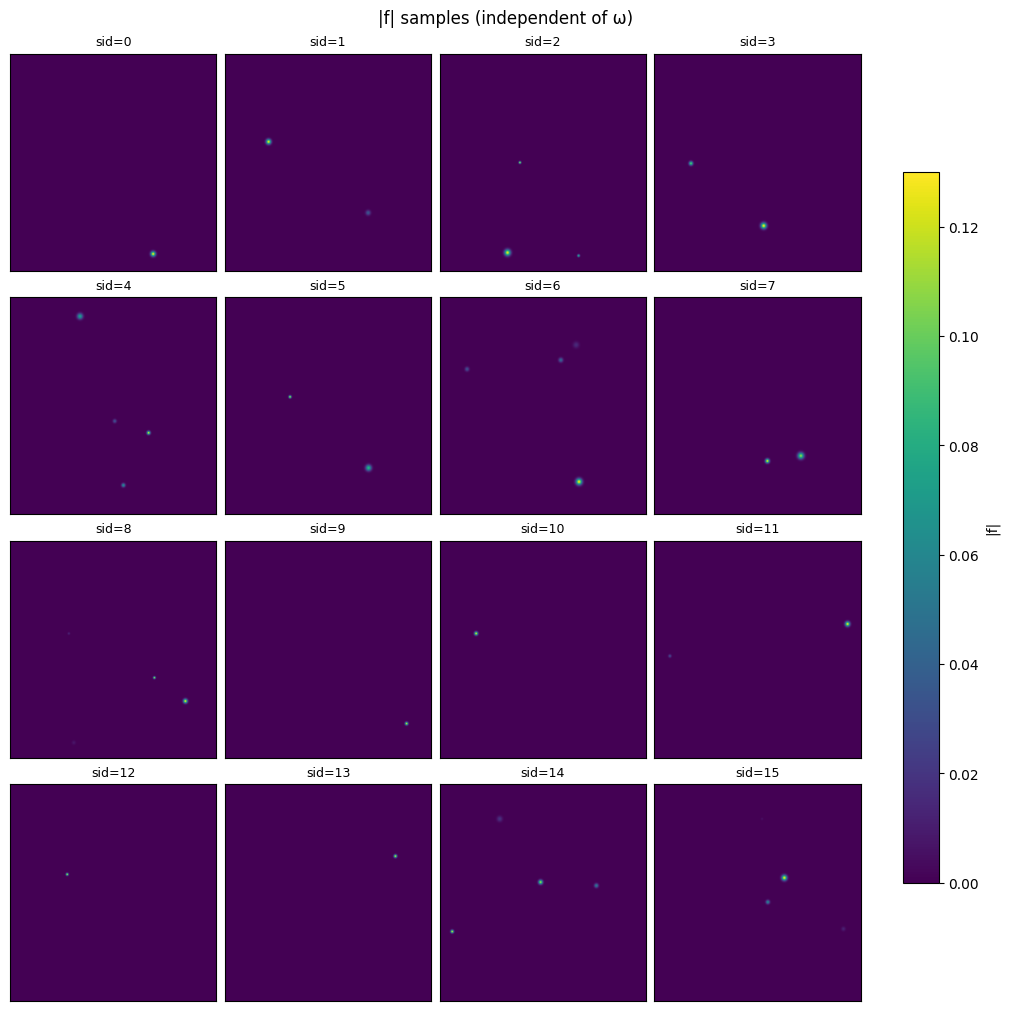

Saved: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\outputs\notebookC_rhs\rhs_samples_abs.png


In [8]:
def plot_rhs_grid(F, nrows=4, ncols=4, title="|f| (RHS samples)", fname="rhs_samples.png"):
    assert nrows * ncols <= F.shape[0]
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10), constrained_layout=True)
    for k, ax in enumerate(axes.ravel()):
        U = F[k].reshape(nx, ny)
        im = ax.imshow(np.abs(U).T, origin="lower", aspect="auto")
        ax.set_title(f"sid={k}", fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])
    fig.suptitle(title)
    cbar = fig.colorbar(im, ax=axes, shrink=0.75)
    cbar.set_label("|f|")
    path = OUTDIR / fname
    fig.savefig(path, dpi=200)
    plt.show()
    print("Saved:", path)

plot_rhs_grid(F_preview, title="|f| samples (independent of ω)", fname="rhs_samples_abs.png")


## 5) Create train/test splits and export

We export RHS-only datasets first (fast), then later you can augment with direct solves `u_{ω'}`, `u_{ω}`.

Outputs:
- `train_rhs.npz`, `test_rhs.npz` (complex arrays)
- `train_meta.json`, `test_meta.json` (metadata list)

> Tip: keep train/test split **by sample_id ranges** for determinism.


In [ ]:
N_train = 512
N_test  = 128

# Generate once (frequency-agnostic RHS)
F_train, meta_train = generate_rhs_batch(N_train, omega_value=64.0)  # omega used only for cfg.omega; seed ignores omega
F_test,  meta_test  = generate_rhs_batch(N_test,  omega_value=64.0)

# Save NPZ (complex arrays are supported by numpy)
np.savez_compressed(OUTDIR / "train_rhs.npz", F=F_train)
np.savez_compressed(OUTDIR / "test_rhs.npz",  F=F_test)

# Save metadata as JSON (complex amps are already stored as re/im pairs)
(OUTDIR / "train_meta.json").write_text(json.dumps(meta_train, indent=2))
(OUTDIR / "test_meta.json").write_text(json.dumps(meta_test, indent=2))

print("Saved:")
print(" -", (OUTDIR / "train_rhs.npz").resolve())
print(" -", (OUTDIR / "test_rhs.npz").resolve())
print(" -", (OUTDIR / "train_meta.json").resolve())
print(" -", (OUTDIR / "test_meta.json").resolve())


## 6) (Optional) Paired bookkeeping for $(\omega', \omega) = (32, 64)$

Because RHS generation is independent of frequency, you can treat the **same** `F_train` as the RHS for both:
- $\omega'=32$
- $\omega=64$

Later, when you add direct solves, you’ll generate:
- `U_train_omega_prime = solve(A(ω'), F_train)`
- `U_train_omega       = solve(A(ω),  F_train)`

For now, we just write a small JSON “manifest”.


In [ ]:
manifest = {
    "omega_prime": 32.0,
    "omega": 64.0,
    "rhs_cfg": rhs_cfg.__dict__,
    "npml": int(npml),
    "pml_margin_cells": int(pml_margin_cells),
    "train_file": "train_rhs.npz",
    "test_file": "test_rhs.npz",
    "note": "RHS is frequency-agnostic (include_omega_in_seed=False). Pairing is by sample_id.",
}

(OUTDIR / "manifest.json").write_text(json.dumps(manifest, indent=2))
print("Saved manifest:", (OUTDIR / "manifest.json").resolve())


## Next step
We’ll now hook this into your real grid/medium/case config objects and add optional:
- direct solves to produce `(f, u_{ω'}, u_{ω})`
- residual checks
- richer RHS families if needed (e.g. modulated Gaussians)
